In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

### UNZIPPING FOLDERS

In [3]:
path_to_zip_file = './sample_data/PlantVillage.zip'
directory_to_extract_to = './sample_data'

In [4]:
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)

 ### Data Preprocessing

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 50
CHANNELS = 3

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./sample_data/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Data Visualization

(32, 256, 256, 3)
[0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 2]


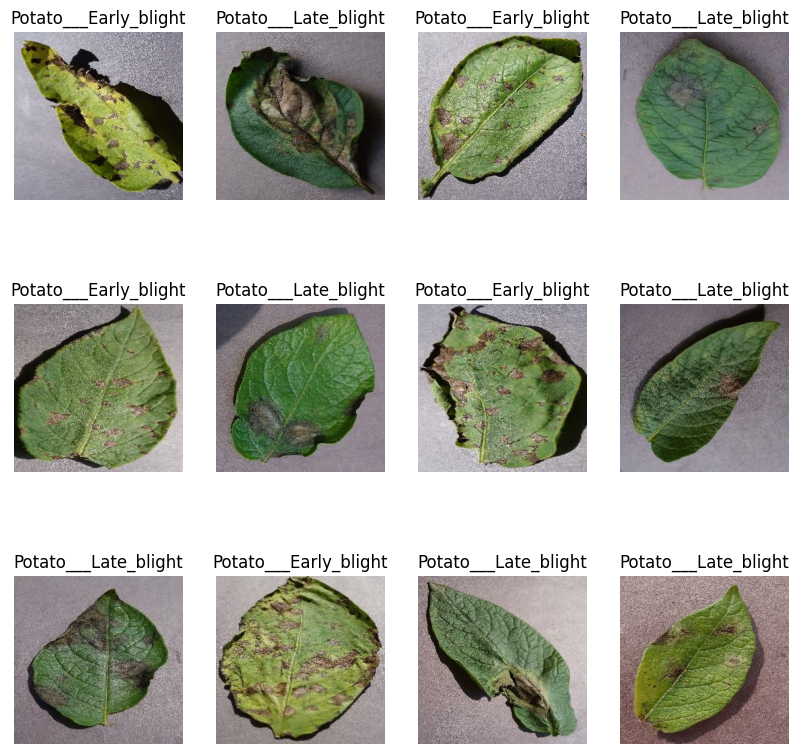

In [8]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.numpy().shape)
  print(labels_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

### Tain Test Split

In [9]:
#convert data into train test split 80% training 10% validation 10% Testing
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

### Splitting Using Functions

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1,
                              test_split = 0.1, shuffle = True, shuffle_size = 100):
  assert(train_split + test_split + val_split) == 1
  ds_size =len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).take(val_size)

  return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(val_ds)

6

### Cache, Shuffle, Prefetch

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.numpy())

[[[[121.  97.  97.]
   [163. 139. 139.]
   [142. 118. 118.]
   ...
   [134. 115. 117.]
   [158. 139. 141.]
   [155. 136. 138.]]

  [[126. 102. 102.]
   [149. 125. 125.]
   [138. 114. 114.]
   ...
   [118.  99. 101.]
   [147. 128. 130.]
   [130. 111. 113.]]

  [[114.  90.  90.]
   [129. 105. 105.]
   [131. 107. 107.]
   ...
   [177. 158. 160.]
   [154. 135. 137.]
   [156. 137. 139.]]

  ...

  [[120. 100.  99.]
   [154. 134. 133.]
   [103.  82.  81.]
   ...
   [159. 145. 145.]
   [159. 145. 145.]
   [148. 134. 134.]]

  [[113.  93.  92.]
   [144. 124. 123.]
   [155. 134. 133.]
   ...
   [167. 153. 153.]
   [135. 121. 121.]
   [147. 133. 133.]]

  [[119.  99.  98.]
   [152. 132. 131.]
   [122. 101. 100.]
   ...
   [153. 139. 139.]
   [153. 139. 139.]
   [146. 132. 132.]]]


 [[[ 91.  87. 102.]
   [112. 108. 123.]
   [139. 135. 150.]
   ...
   [167. 165. 179.]
   [161. 159. 173.]
   [154. 152. 166.]]

  [[110. 106. 121.]
   [116. 112. 127.]
   [106. 102. 117.]
   ...
   [156. 154. 168.]
 

### Preprocessing During Model Creation

In [25]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

### Data Augmentation

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

### Model Creation

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [28]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size =(3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax'),

])

In [29]:
model.build(input_shape = input_shape)

### Model Summary

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [31]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### Training The Model

In [32]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 415s 8s/step - loss: 0.8779 - accuracy: 0.5579 - val_loss: 0.7123 - val_accuracy: 0.7083
Epoch 2/50
54/54 [==============================] - 390s 7s/step - loss: 0.6026 - accuracy: 0.7523 - val_loss: 0.4602 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 373s 7s/step - loss: 0.4186 - accuracy: 0.8293 - val_loss: 0.3419 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 362s 7s/step - loss: 0.3032 - accuracy: 0.8791 - val_loss: 0.3636 - val_accuracy: 0.8594
Epoch 5/50
54/54 [==============================] - 368s 7s/step - loss: 0.2475 - accuracy: 0.8958 - val_loss: 0.3368 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 373s 7s/step - loss: 0.2255 - accuracy: 0.9103 - val_loss: 0.3203 - val_accuracy: 0.8646
Epoch 7/50
54/54 [==============================] - 366s 7s/step - loss: 0.2153 - accuracy: 0.9196 - val_loss: 0.2099 - val_accuracy: 0.9219
Epoch 8/50
54

In [33]:
len(test_ds)

6

### Accuracy

In [34]:
score = model.evaluate(test_ds)

6/6 [==============================] - 15s 2s/step - loss: 0.0855 - accuracy: 0.9740


In [35]:
score

[0.08549445122480392, 0.9739583134651184]

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Training History

In [37]:
history.history['accuracy']

[0.5578703880310059,
 0.7523148059844971,
 0.8292824029922485,
 0.8790509104728699,
 0.8958333134651184,
 0.9103009104728699,
 0.9195601940155029,
 0.9288194179534912,
 0.9299768805503845,
 0.9224537014961243,
 0.9513888955116272,
 0.9432870149612427,
 0.9311342835426331,
 0.9444444179534912,
 0.953125,
 0.9606481194496155,
 0.9664351940155029,
 0.9438657164573669,
 0.9612268805503845,
 0.9594907164573669,
 0.9600694179534912,
 0.9583333134651184,
 0.9785879850387573,
 0.9710648059844971,
 0.9780092835426331,
 0.9768518805503845,
 0.9768518805503845,
 0.9803240895271301,
 0.9814814925193787,
 0.9791666865348816,
 0.9728009104728699,
 0.9849537014961243,
 0.9826388955116272,
 0.9785879850387573,
 0.9797453880310059,
 0.9803240895271301,
 0.9820601940155029,
 0.9895833134651184,
 0.9861111044883728,
 0.9884259104728699,
 0.9768518805503845,
 0.9890046119689941,
 0.984375,
 0.9895833134651184,
 0.9930555820465088,
 0.9571759104728699,
 0.9895833134651184,
 0.9849537014961243,
 0.980324089

In [38]:
history.history['loss'][:5]

[0.8778904676437378,
 0.602632462978363,
 0.4186273515224457,
 0.3032316267490387,
 0.24750873446464539]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Graphical Representation Of Accuracy

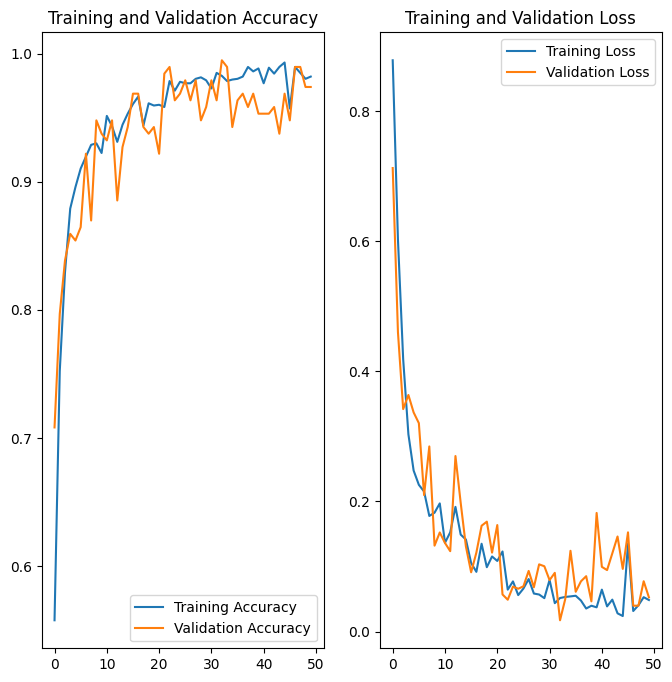

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


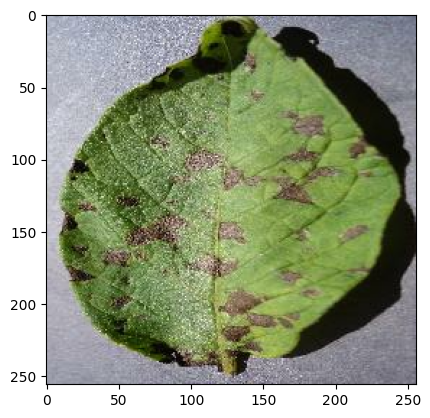

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Prediction Function

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Predictions

1/1 [==============================] - 0s 66ms/step


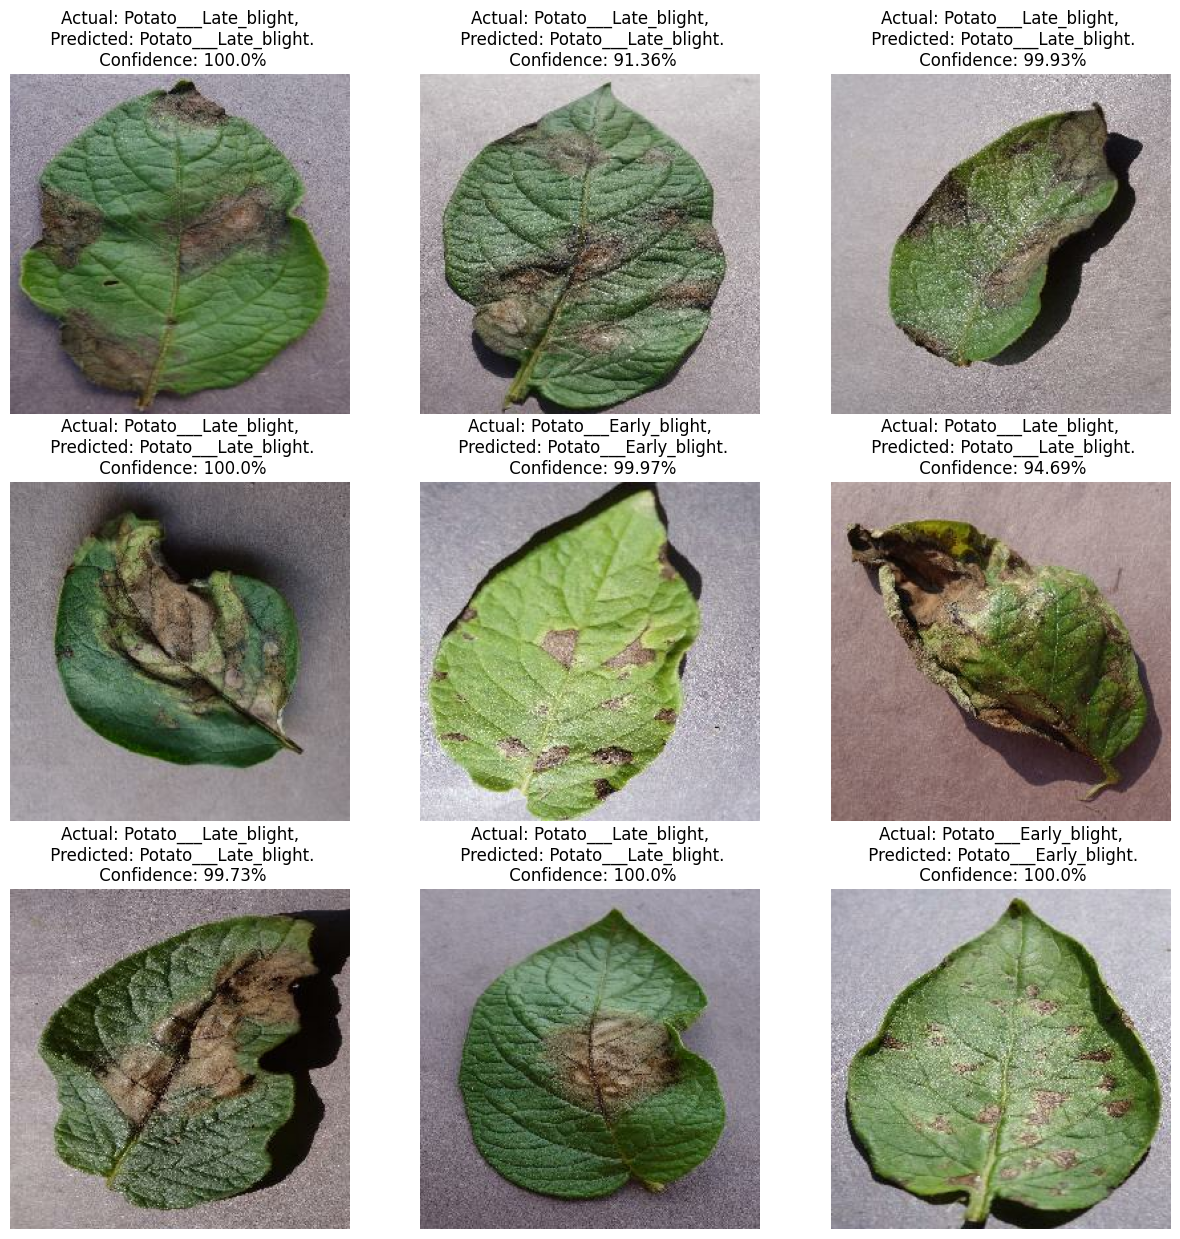

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")